<a href="https://colab.research.google.com/github/Jagoda222/DL-assignment1/blob/main/Assignment_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import scipy.io
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras import regularizers

mat = scipy.io.loadmat('/content/Xtrain.mat')
data = mat['Xtrain']

# Data Analysis and Preparation

### Normalization

In [ ]:
import numpy as np
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

norm_xrays= normalize_array(data)

def denormalize_array(norm_arr, original_arr):
    denorm_arr = norm_arr * (np.max(original_arr) - np.min(original_arr)) + np.min(original_arr)
    return denorm_arr

### Visual Analysis

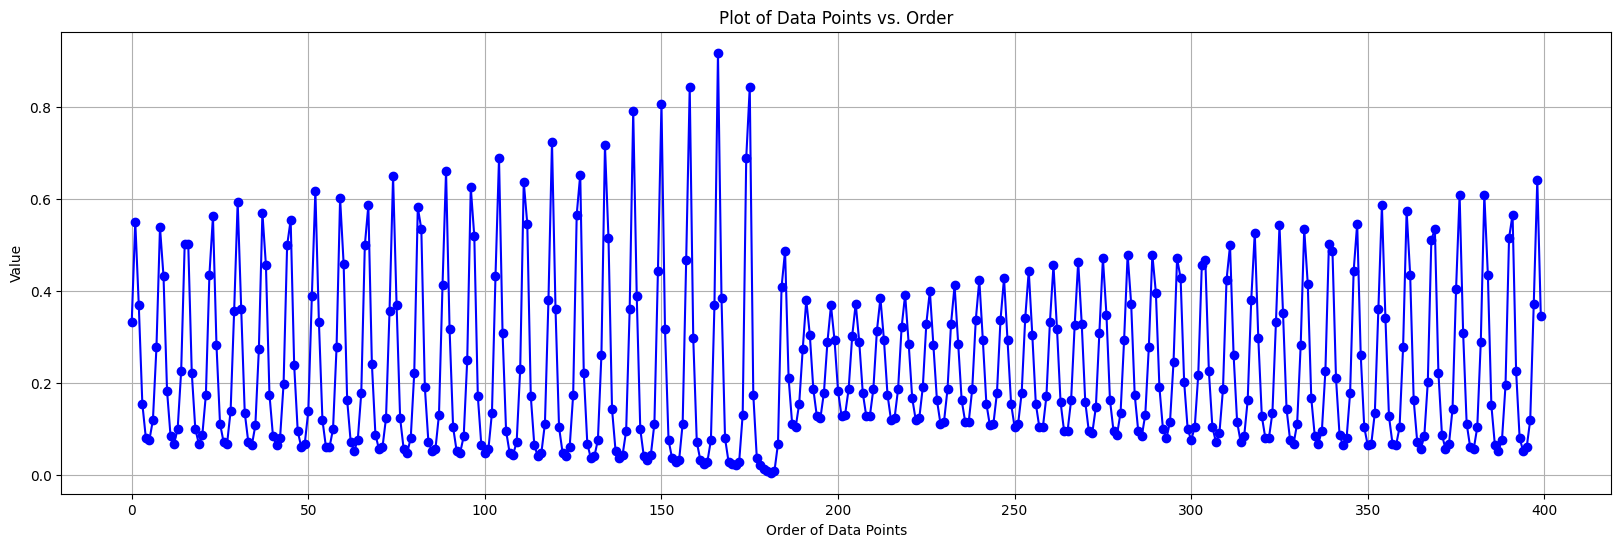

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_values = np.arange(0,1000)


x_subset = x_values[:400]
y_subset = norm_xrays[:400]

plt.figure(figsize=(20, 6))
plt.plot(x_subset, y_subset, marker='o', color='b', linestyle='-', label='Data points')


plt.xlabel('Order of Data Points')
plt.ylabel('Value')
plt.title('Plot of Data Points vs. Order')
plt.grid(True)
plt.show()

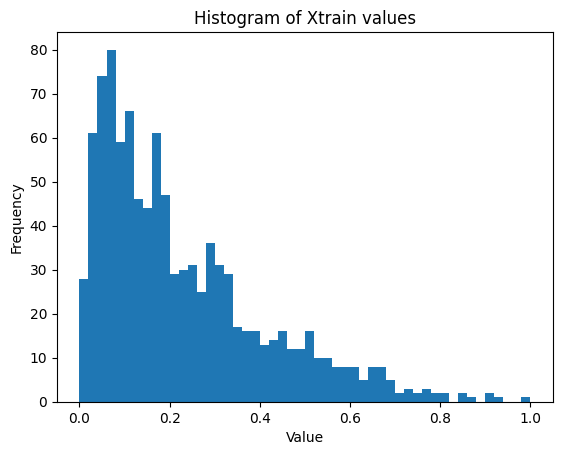

In [ ]:
plt.hist(norm_xrays.flatten(), bins=50)
plt.title("Histogram of Xtrain values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
mean_value = np.mean(norm_xrays)
std_dev = np.std(norm_xrays)
#min_value = np.min(norm_xrays)
#max_value = np.max(norm_xrays)

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_dev}")
#print(f"Min Value: {min_value}")
#print(f"Max Value: {max_value}")


Mean: 0.22883003952569173
Standard Deviation: 0.1851857226641462


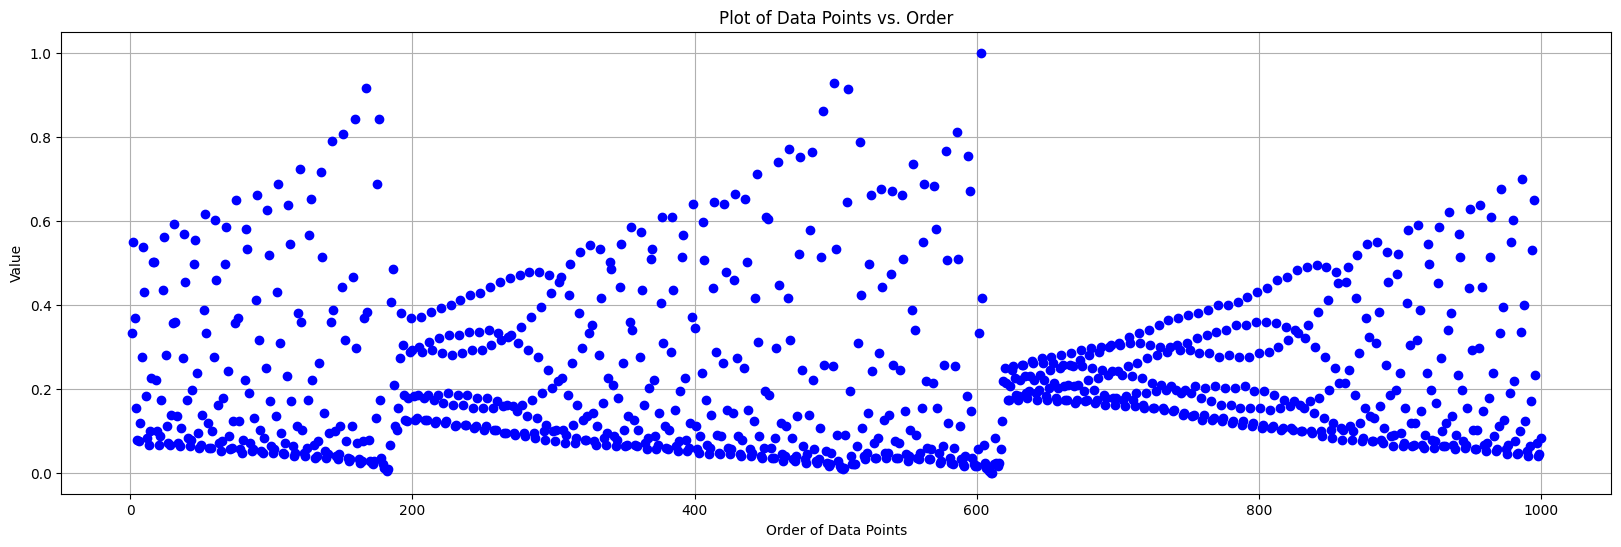

In [ ]:

x_values = np.arange(1, len(norm_xrays) + 1)


plt.figure(figsize=(20, 6))
plt.plot(x_values, norm_xrays, marker='o', color='b', linestyle='None', label='Data points')
plt.xlabel('Order of Data Points')
plt.ylabel('Value')
plt.title('Plot of Data Points vs. Order')
plt.grid(True)
plt.show()


### Data Preparation - Labelling and Splitting

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Labelling
def create_sequences(data, window_size, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon])
    return np.array(X), np.array(y)

def rolling_forecast_split(data, window_size, initial_train_size, horizon=1, step=1):
    X_all, y_all = create_sequences(data, window_size, horizon)

    n_samples = len(X_all)
    splits = []

    for i in range(initial_train_size, n_samples, step):
        X_train = X_all[:i]
        y_train = y_all[:i]
        X_val = X_all[i:i+step]
        y_val = y_all[i:i+step]
        if len(X_val) == 0:
            break
        splits.append((X_train, X_val, y_train, y_val))

    X_train_all = []
    y_train_all = []
    X_val_all = []
    y_val_all = []

    for X_train, X_val, y_train, y_val in splits:
        X_train_all.append(X_train)
        y_train_all.append(y_train)
        X_val_all.append(X_val)
        y_val_all.append(y_val)


    # Concatenate into final datasets
    X_train_final = np.concatenate(X_train_all, axis=0)
    y_train_final = np.concatenate(y_train_all, axis=0)
    X_val_final = np.concatenate(X_val_all, axis=0)
    y_val_final = np.concatenate(y_val_all, axis=0)

    return X_train_final, X_val_final, y_train_final, y_val_final

X_train, X_val, y_train, y_val = rolling_forecast_split(norm_xrays, window_size=100, initial_train_size=200, horizon=1, step=10)



In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(38150, 100, 1)
(38150, 1, 1)
(700, 100, 1)
(700, 1, 1)


# Benchmarks

In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(name, y_true, y_pred):
    y_true = y_true.reshape(-1,1)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}")

In [ ]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense

def build_benchmark(model_type, optimizer):
  set_seed()

  model = Sequential()
  model.add(Input((X_train.shape[1], 1)))

  if model_type == 'RNN':
    model.add(SimpleRNN(64,))
  elif model_type == 'LSTM':
    model.add(LSTM(64,))
  elif model_type == 'GRU':
    model.add(GRU(64,))

  model.add(Dense(1, activation='relu'))
  if optimizer == 'SGD':
    model.compile(optimizer='SGD', loss='mse')
  elif optimizer == 'RMSprop':
    model.compile(optimizer='RMSprop', loss='mse')
  elif optimizer == 'Adagrad':
    model.compile(optimizer='Adagrad', loss='mse')
  elif optimizer == 'Adam':
     model.compile(optimizer='Adam', loss='mse')

  return model

## Vanilla RNN

In [ ]:
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adam']

for optimizer in optimizers:
    model_name = f"RNN_{optimizer}"
    history_name = f"RNN_{optimizer}_history"
    pred_name = f"RNN_{optimizer}_pred"

    globals()[model_name] = build_benchmark(model_type='RNN', optimizer=optimizer)
    globals()[history_name] = globals()[model_name].fit(
        X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0,
    )
    globals()[pred_name] = globals()[model_name].predict(X_val)

    evaluate_model(f"Vanilla RNN with {optimizer}", y_val, globals()[pred_name])


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Vanilla RNN with SGD - MSE: 0.0046, MAE: 0.0436
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Vanilla RNN with RMSprop - MSE: 0.0015, MAE: 0.0244
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Vanilla RNN with Adagrad - MSE: 0.0051, MAE: 0.0414
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Vanilla RNN with Adam - MSE: 0.0136, MAE: 0.0812


## LSTM

In [ ]:
for optimizer in optimizers:
    model_name = f"LSTM_{optimizer}"
    history_name = f"LSTM_{optimizer}_history"
    pred_name = f"LSTM_{optimizer}_pred"

    globals()[model_name] = build_benchmark(model_type='LSTM', optimizer=optimizer)
    globals()[history_name] = globals()[model_name].fit(
        X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0
    )
    globals()[pred_name] = globals()[model_name].predict(X_val)

    evaluate_model(f"LSTM with {optimizer}", y_val, globals()[pred_name])

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM with SGD - MSE: 0.0298, MAE: 0.1335
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM with RMSprop - MSE: 0.0003, MAE: 0.0148
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM with Adagrad - MSE: 0.0333, MAE: 0.1421
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM with Adam - MSE: 0.0856, MAE: 0.2275


## GRU

In [ ]:
for optimizer in optimizers:

    model_name = f"GRU_{optimizer}"
    history_name = f"GRU_{optimizer}_history"
    pred_name = f"GRU_{optimizer}_pred"

    globals()[model_name] = build_benchmark(model_type='GRU', optimizer=optimizer)
    globals()[history_name] = globals()[model_name].fit(
        X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0,
    )
    globals()[pred_name] = globals()[model_name].predict(X_val)

    evaluate_model(f"GRU with {optimizer}", y_val, globals()[pred_name])

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
GRU with SGD - MSE: 0.0149, MAE: 0.0823
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU with RMSprop - MSE: 0.0012, MAE: 0.0262
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
GRU with Adagrad - MSE: 0.0285, MAE: 0.1303
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU with Adam - MSE: 0.0003, MAE: 0.0084


## Analysis

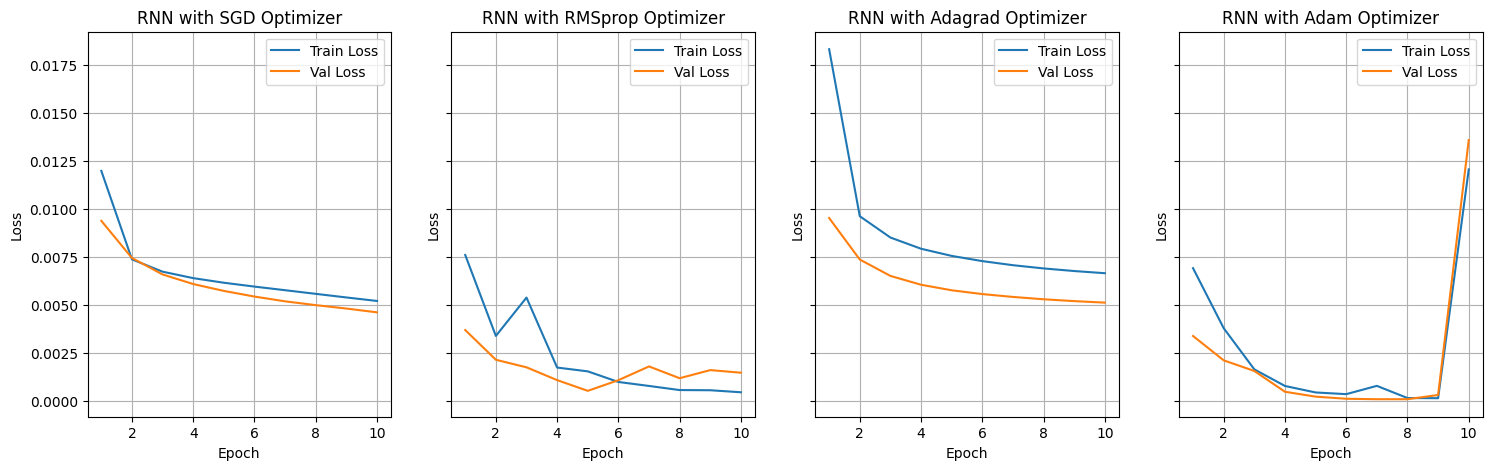

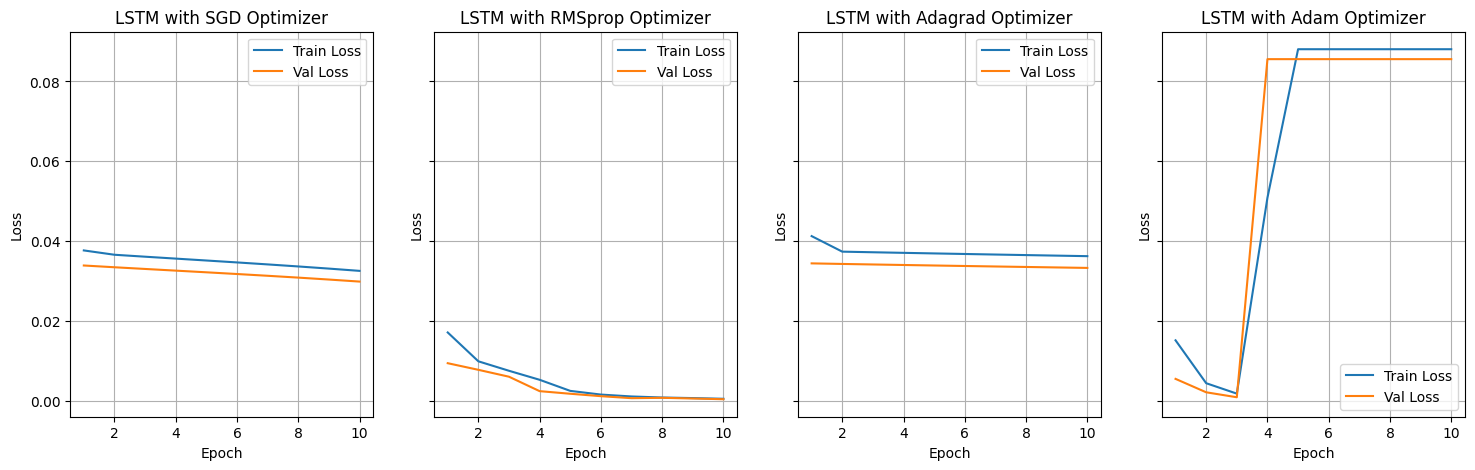

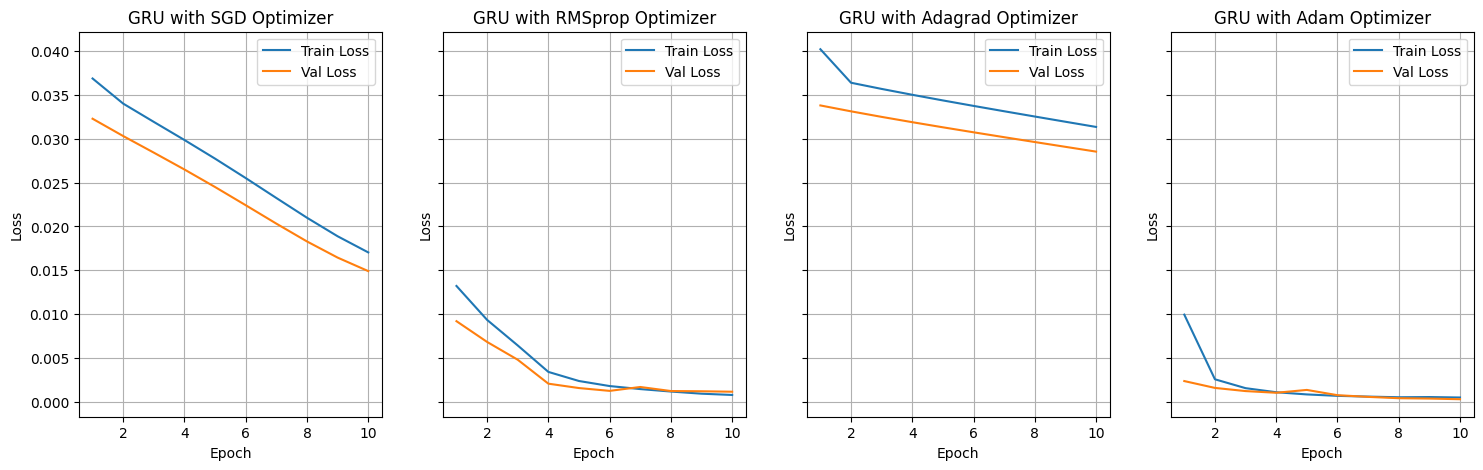

In [ ]:
epochs = range(1,11)
models = ['RNN', 'LSTM', 'GRU']

for i in models:
    fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
    for j in optimizers:

        history_var = globals()[f"{i}_{j}_history"]
        axes[optimizers.index(j)].plot(epochs, history_var.history['loss'], label='Train Loss')
        axes[optimizers.index(j)].plot(epochs, history_var.history['val_loss'], label='Val Loss')
        axes[optimizers.index(j)].set_title(f"{i} with {j} Optimizer")
        axes[optimizers.index(j)].set_xlabel("Epoch")
        axes[optimizers.index(j)].set_ylabel("Loss")
        axes[optimizers.index(j)].legend()
        axes[optimizers.index(j)].grid(True)


# Model Architectures

## GRU + GRU

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
GRU-GRU - MSE: 0.0001, MAE: 0.0059


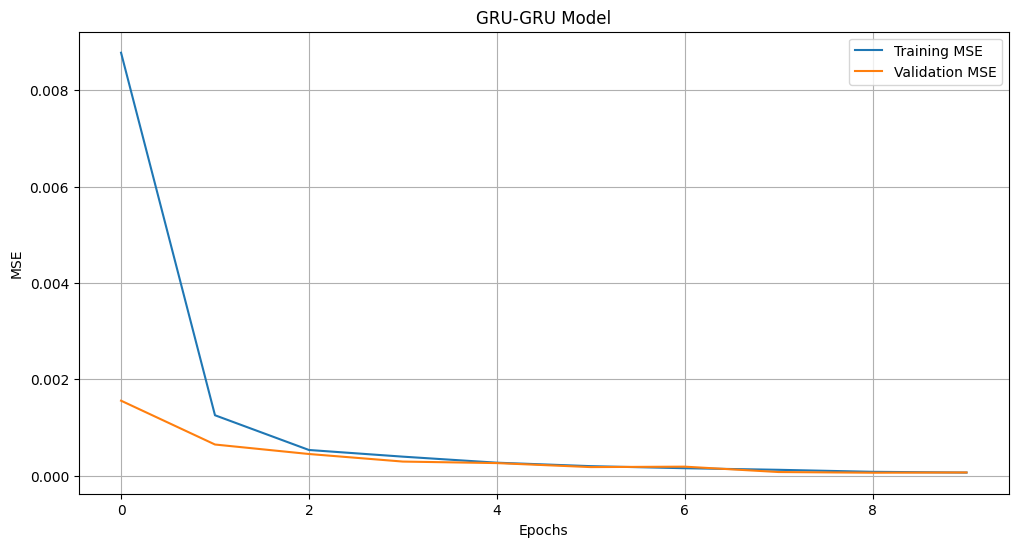

In [ ]:
gru2 = Sequential()
gru2.add(Input((X_train.shape[1], 1)))
gru2.add(GRU(64, return_sequences = True))
gru2.add(GRU(64,))
gru2.add(Dense(1))
gru2.compile(optimizer='Adam', loss='mse')

gru2_hist = gru2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True)


gru2_pred = gru2.predict(X_val)
evaluate_model("GRU-GRU", y_val, gru2_pred)

plt.figure(figsize=(12, 6))
plt.plot(gru2_hist.history['loss'], label='Training MSE')
plt.plot(gru2_hist.history['val_loss'], label='Validation MSE')
plt.title('GRU-GRU Model')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

## CNN + GRU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
CNN-GRU - MSE: 0.0001, MAE: 0.0074


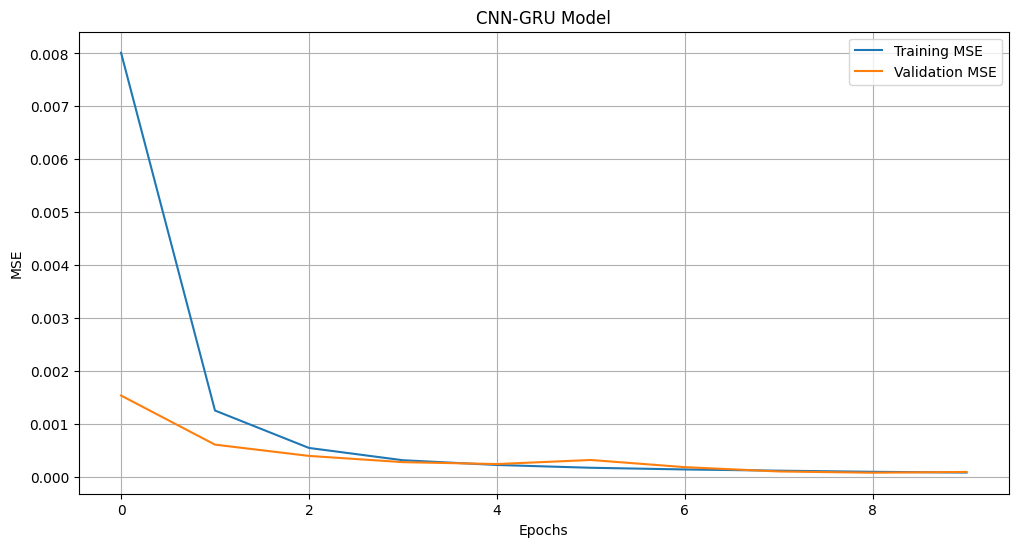

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_gru = Sequential()
cnn_gru.add(Input((X_train.shape[1], 1)))
cnn_gru.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_gru.add(MaxPooling1D(pool_size=2))
cnn_gru.add(GRU(64,))
cnn_gru.add(Dense(1))
cnn_gru.compile(optimizer='Adam', loss='mse')

cnn_gru_hist = cnn_gru.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle = True)


cnn_gru_pred = cnn_gru.predict(X_val)
evaluate_model("CNN-GRU", y_val, cnn_gru_pred)

plt.figure(figsize=(12, 6))
plt.plot(cnn_gru_hist.history['loss'], label='Training MSE')
plt.plot(cnn_gru_hist.history['val_loss'], label='Validation MSE')
plt.title('CNN-GRU Model')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

## CNN + GRU + GRU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
CNN-GRU-GRU - MSE: 0.0000, MAE: 0.0049


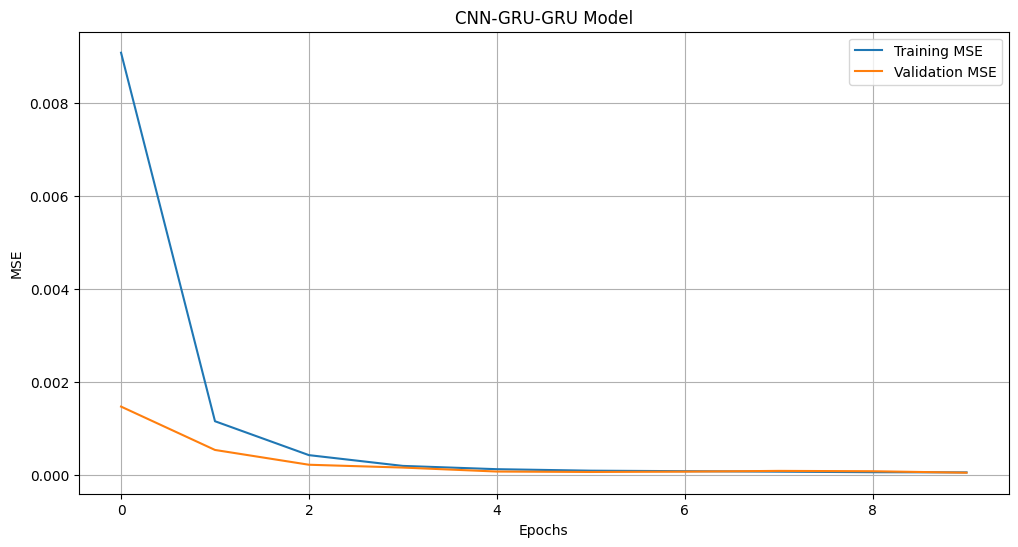

In [ ]:

cnn_gru2 = Sequential()
cnn_gru2.add(Input((X_train.shape[1], 1)))
cnn_gru2.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_gru2.add(MaxPooling1D(pool_size=2))
cnn_gru2.add(GRU(64, return_sequences = True))
cnn_gru2.add(GRU(64,))
cnn_gru2.add(Dense(1))
cnn_gru2.compile(optimizer='Adam', loss='mse')


cnn_gru2_hist = cnn_gru2.fit(X_train, y_train, epochs = 10, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle = True)

cnn_gru2_pred = cnn_gru2.predict(X_val)
evaluate_model("CNN-GRU-GRU", y_val, cnn_gru2_pred)

plt.figure(figsize=(12, 6))
plt.plot(cnn_gru2_hist.history['loss'], label='Training MSE')
plt.plot(cnn_gru2_hist.history['val_loss'], label='Validation MSE')
plt.title('CNN-GRU-GRU Model')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

## GRU + GRU + GRU

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
GRU-GRU-GRU - MSE: 0.0001, MAE: 0.0065


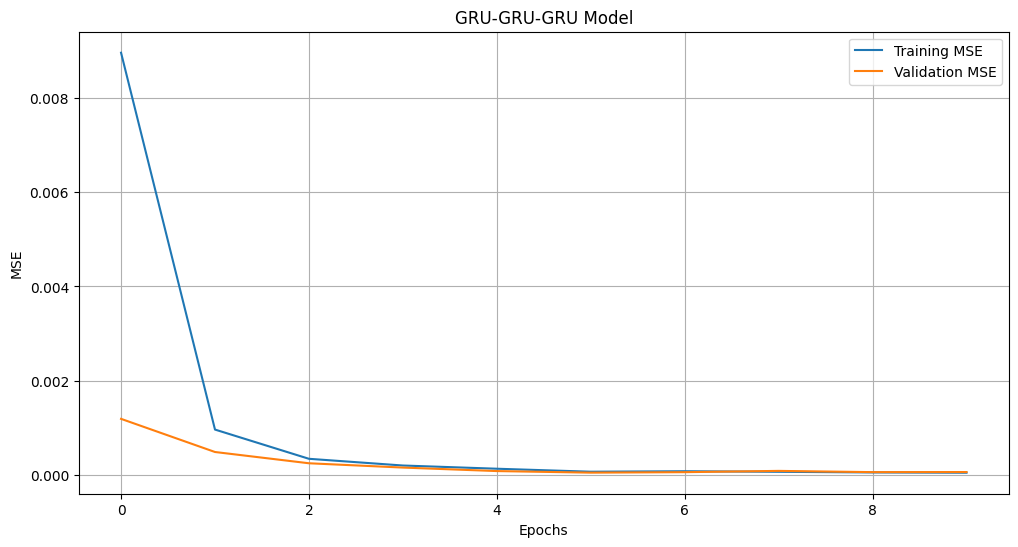

In [ ]:
import keras
gru3 = Sequential()
gru3.add(Input((X_train.shape[1], 1)))
gru3.add(GRU(64, return_sequences = True))
gru3.add(GRU(64, return_sequences = True))
gru3.add(GRU(64,))
gru3.add(Dense(1))
gru3.compile(optimizer=keras.optimizers.Adam(), loss='mse')

gru3_hist = gru3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle = True)

gru3_pred = gru3.predict(X_val)
evaluate_model("GRU-GRU-GRU", y_val, gru3_pred)

plt.figure(figsize=(12, 6))
plt.plot(gru3_hist.history['loss'], label='Training MSE')
plt.plot(gru3_hist.history['val_loss'], label='Validation MSE')
plt.title('GRU-GRU-GRU Model')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Hyperparameter Tuning

In [ ]:
#pip install keras-tuner

In [ ]:
'''
import keras_tuner as kt

def build_model(hp):
    set_seed()

    # Tunable parameters
    window_size = hp.Int('window_size', min_value=50, max_value=100, step=10)
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')


    model = Sequential()
    model.add(Input((window_size, 1)))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics= ['mae'])
    return model

class MyTuner(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        batch_size = hp.Choice('batch_size', [32, 64, 128])

        return super().run_trial(trial, *args, **kwargs, batch_size=batch_size)

tuner = MyTuner(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='time_series_forecasting',
    overwrite=True
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=3)

tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[stop_early],
    verbose=1
)
'''

"\nimport keras_tuner as kt\n\ndef build_model(hp):\n    set_seed()\n\n    # Tunable parameters\n    window_size = hp.Int('window_size', min_value=50, max_value=100, step=10)\n    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')\n\n\n    model = Sequential()\n    model.add(Input((window_size, 1)))\n    model.add(GRU(64, return_sequences=True))\n    model.add(GRU(64))\n    model.add(Dense(1))\n    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics= ['mae'])\n    return model\n\nclass MyTuner(kt.BayesianOptimization):\n    def run_trial(self, trial, *args, **kwargs):\n        hp = trial.hyperparameters\n        batch_size = hp.Choice('batch_size', [32, 64, 128])\n\n        return super().run_trial(trial, *args, **kwargs, batch_size=batch_size)\n\ntuner = MyTuner(\n    build_model,\n    objective='val_loss',\n    max_trials=10,\n    executions_per_trial=1,\n    directory='tuner_logs',\n    project_name='time_series_forecasting',\n    overwrit

In [ ]:
#print(tuner.results_summary())
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
#best_model = tuner.hypermodel.build(best_hps)
#best_model.summary()

In [ ]:
'''
window_size = best_hps.get('window_size')
batch_size = best_hps.get('batch_size')
lr = best_hps.get('learning_rate')

def build_tuned_model(window_size, lr):
    set_seed()

    model = Sequential()
    model.add(Input((window_size, 1)))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics= ['mae'])
    return model

tuned_model = build_tuned_model(window_size, lr)

X_train, X_val, y_train, y_val = rolling_forecast_split(norm_xrays, window_size=window_size, initial_train_size=200, horizon=1, step=10)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
'''

"\nwindow_size = best_hps.get('window_size')\nbatch_size = best_hps.get('batch_size')\nlr = best_hps.get('learning_rate')\n\ndef build_tuned_model(window_size, lr):\n    set_seed()\n\n    model = Sequential()\n    model.add(Input((window_size, 1)))\n    model.add(GRU(64, return_sequences=True))\n    model.add(GRU(64, return_sequences=True))\n    model.add(Dense(1))\n    model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics= ['mae'])\n    return model\n\ntuned_model = build_tuned_model(window_size, lr)\n\nX_train, X_val, y_train, y_val = rolling_forecast_split(norm_xrays, window_size=window_size, initial_train_size=200, horizon=1, step=10)\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint(X_val.shape)\nprint(y_val.shape)\n"

In [ ]:
#history = tuned_model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, shuffle=True)

In [ ]:
'''
import matplotlib.pyplot as plt

# Plot MSE and MAE
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Mean Squared Error (MSE) by Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error (MAE) by Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
'''

"\nimport matplotlib.pyplot as plt\n\n# Plot MSE and MAE\nplt.figure(figsize=(12, 5))\n\n# MSE\nplt.subplot(1, 2, 1)\nplt.plot(history.history['loss'], label='Train MSE')\nplt.plot(history.history['val_loss'], label='Val MSE')\nplt.title('Mean Squared Error (MSE) by Epoch')\nplt.xlabel('Epoch')\nplt.ylabel('MSE')\nplt.legend()\n\n# MAE\nplt.subplot(1, 2, 2)\nplt.plot(history.history['mae'], label='Train MAE')\nplt.plot(history.history['val_mae'], label='Val MAE')\nplt.title('Mean Absolute Error (MAE) by Epoch')\nplt.xlabel('Epoch')\nplt.ylabel('MAE')\nplt.legend()\n"

# Generating 200 points

In [ ]:
final_model = gru2

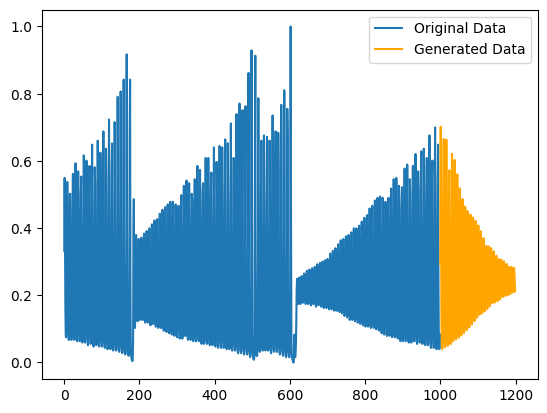

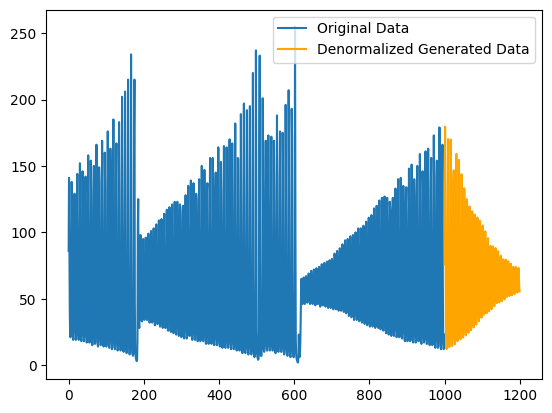

In [ ]:
def generate_next_points(model, input_data, window_size, steps=200):
    pred_seq = []

    input_data = np.reshape(input_data, (-1, 1))  # Ensure shape (n_samples, 1)

    for i in range(steps):

        # Get the last window and reshape for the model
        last_window = input_data[-window_size:].reshape(1, window_size, 1)

        prediction = model.predict(last_window, verbose=0)
        next_point = prediction[0, -1]  # Get the last predicted value
        # print(f'Point {i}:', next_point)

        # Append to prediction list and update input
        pred_seq.append(next_point)
        input_data = np.vstack([input_data, [next_point]])

    return np.array(pred_seq)


predicted_200_points = generate_next_points(final_model, norm_xrays, window_size=100, steps=200)


import matplotlib.pyplot as plt

plt.plot(np.arange(len(norm_xrays)), norm_xrays, label="Original Data")
plt.plot(np.arange(len(norm_xrays), len(norm_xrays) + len(predicted_200_points)), predicted_200_points, label="Generated Data", color='orange')
plt.legend()
plt.show()

den_pred_200 = denormalize_array(predicted_200_points, data)
plt.plot(np.arange(len(norm_xrays)), data, label="Original Data")
plt.plot(np.arange(len(norm_xrays), len(norm_xrays) + len(predicted_200_points)), den_pred_200, label="Denormalized Generated Data", color='orange')
plt.legend()
plt.show()



# Testing

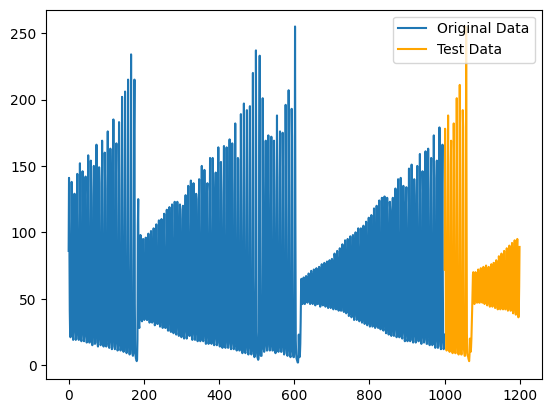

In [ ]:
mat = scipy.io.loadmat('/content/Xtest.mat')
test_data = mat['Xtest']
plt.plot(np.arange(len(data)), data, label="Original Data")
plt.plot(np.arange(len(data), len(data) + len(test_data)), test_data, label="Test Data", color='orange')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Model Evaluation - MSE: 0.0031, MAE: 0.0261


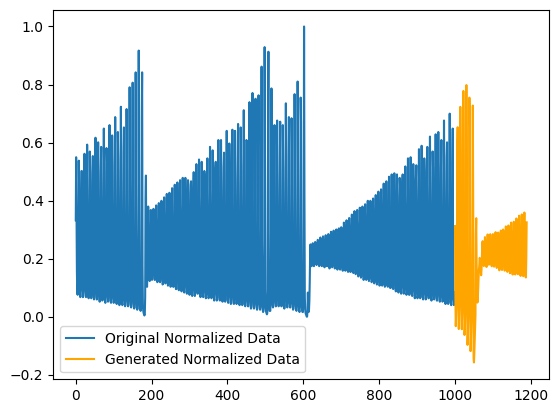

In [ ]:
norm_test_data = normalize_array(test_data)
X_test_norm, y_test_norm = create_sequences(norm_test_data, window_size=10)

y_pred_norm = final_model.predict(X_test_norm)

evaluate_model("Model Evaluation", y_test_norm, y_pred_norm)
plt.plot(np.arange(len(norm_xrays)), norm_xrays, label="Original Normalized Data")
plt.plot(np.arange(len(norm_xrays), len(norm_xrays) + len(y_pred_norm)), y_pred_norm, label="Generated Normalized Data", color='orange')
plt.legend()
plt.show()


Model Evaluation - MSE: 200.7767, MAE: 6.8013


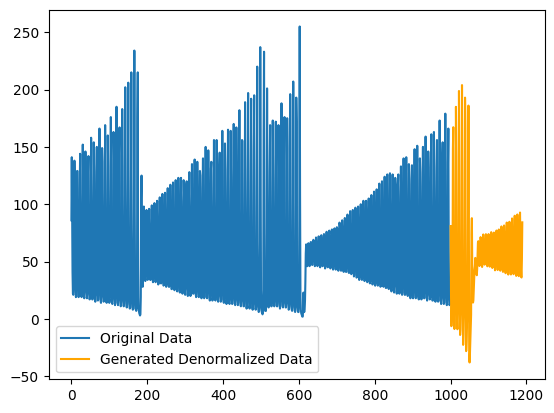

In [ ]:
 y_pred_denorm = denormalize_array(y_pred_norm, data)
 X_test, y_test = create_sequences(test_data, window_size=10)
 evaluate_model("Model Evaluation", y_test, y_pred_denorm)
 plt.plot(np.arange(len(data)), data, label="Original Data")
 plt.plot(np.arange(len(data), len(data) + len(y_pred_denorm)), y_pred_denorm, label="Generated Denormalized Data", color='orange')
 plt.legend()
 plt.show()

In [ ]:
y_test = y_test.flatten()
y_pred_denorm = y_pred_denorm.flatten()
print(y_test.shape)
print(y_pred_denorm.shape)

(190,)
(190,)


In [ ]:
import pandas as pd
df = pd.DataFrame({
    "Actual values": y_test,
    "Predicted values": y_pred_denorm})

df

,Actual values,Predicted values
0,80,80.984421
1,23,22.065178
2,12,-6.331515
3,10,1.866472
4,15,17.628330
...,...,...
185,47,47.542591
186,36,36.814613
187,40,36.092373
188,59,52.732079


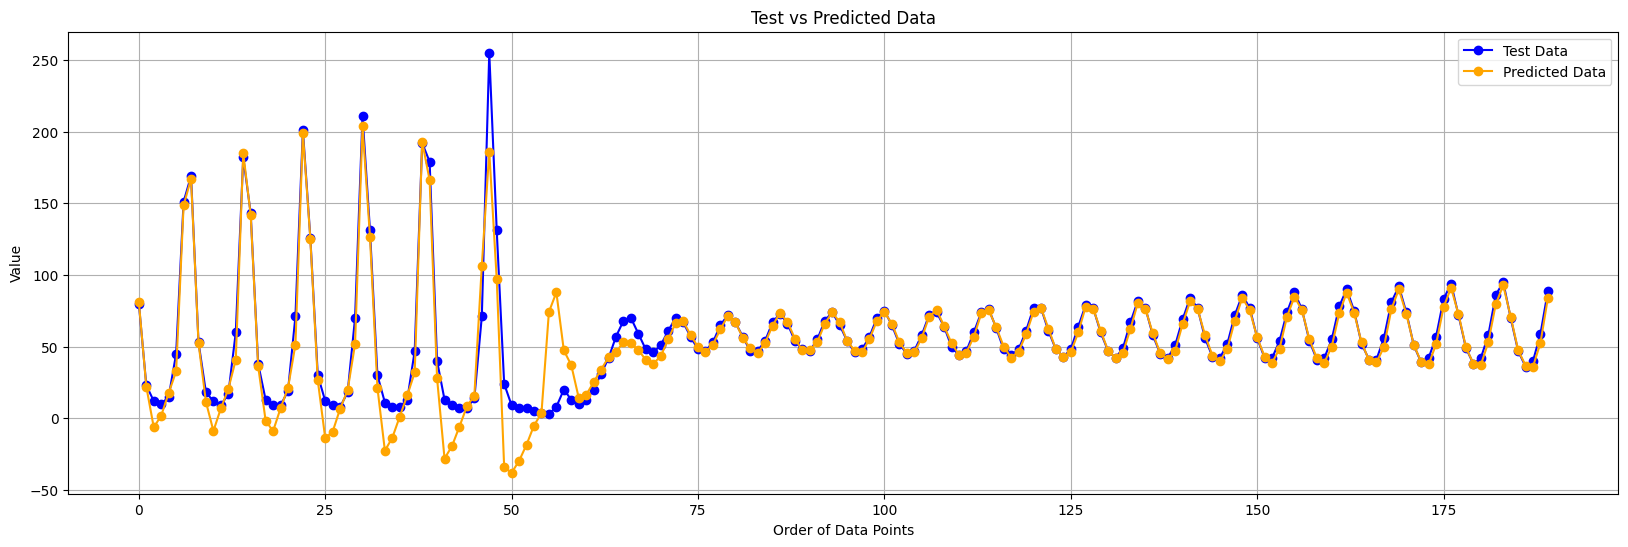

In [ ]:
x_values = np.arange(0, 190)

plt.figure(figsize=(20, 6))
plt.plot(x_values, y_test, marker='o', color='b', linestyle='-', label='Test Data')
plt.plot(x_values, y_pred_denorm, marker='o', color='orange', linestyle='-', label='Predicted Data')

plt.xlabel('Order of Data Points')
plt.ylabel('Value')
plt.title('Test vs Predicted Data')
plt.grid(True)
plt.legend()
plt.show()